# 🔥 VLM Comparison in DDPO: Beyond LLaVA

This notebook demonstrates a comprehensive comparison of different Vision-Language Models (VLMs) in the context of DDPO (Denoising Diffusion Policy Optimization).

## 🎯 What you'll learn:
- **Multi-VLM Support**: Compare LLaVA, BLIP-2, InstructBLIP, and CLIP
- **Robustness Analysis**: Test against typographic attacks, adversarial patches, and corruption
- **Efficiency Benchmarking**: Memory usage, inference speed, and throughput analysis
- **DDPO Integration**: How to use different VLMs as reward functions

## 🚀 Key Features:
- **Automatic model selection** based on available GPU memory
- **Interactive visualizations** of model comparisons
- **Real-time robustness testing** with adversarial examples
- **Performance benchmarking** across different metrics

In [1]:
# =============================================================================
# CELL 1: Environment Setup and Imports
# =============================================================================

# Standard library imports
import os
import sys
import time
import json
import warnings
from pathlib import Path

# Scientific computing
import torch
import numpy as np
import pandas as pd

# Image processing and visualization
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add parent directory to path for DDPO imports
sys.path.append(str(Path.cwd().parent))

# DDPO imports
from ddpo_pytorch.vlm_comparison import VLMComparator
from ddpo_pytorch import rewards
import config.vlm_comparison as vlm_config

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Environment validation
print("🔥 VLM Comparison Demo - Setup Complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🔥 VLM Comparison Demo - Setup Complete!
PyTorch version: 2.1.0
CUDA available: True
GPU memory: 25.8 GB


In [2]:
# =============================================================================
# CELL 2: Test Image Creation Functions
# =============================================================================

def create_test_images():
    """Create a variety of test images with emojis and text"""
    def create_simple_image(text, bg_color, text_color='white', size=(256, 256)):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)
        
        # Try to load a font, fall back to default
        try:
            font = ImageFont.load_default()
        except:
            font = None
        
        # Center the text
        if font:
            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
        else:
            text_width, text_height = len(text) * 10, 20
        
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2
        
        draw.text((x, y), text, fill=text_color, font=font)
        return img
    
    test_images = [
        (create_simple_image("🐱 CAT", "orange"), "a cat sitting peacefully"),
        (create_simple_image("🐕 DOG", "brown"), "a friendly dog"),
        (create_simple_image("🐦 BIRD", "skyblue"), "a bird flying"),
        (create_simple_image("🐠 FISH", "cyan"), "a fish swimming"),
        (create_simple_image("🌅 SUNSET", "purple"), "a beautiful sunset")
    ]
    
    return test_images

print("✅ Test image creation functions defined")

✅ Test image creation functions defined


In [3]:
# =============================================================================
# CELL 3: Generate Test Dataset
# =============================================================================

# Create test data
test_data = create_test_images()
print(f"✅ Created {len(test_data)} test images")

✅ Created 5 test images


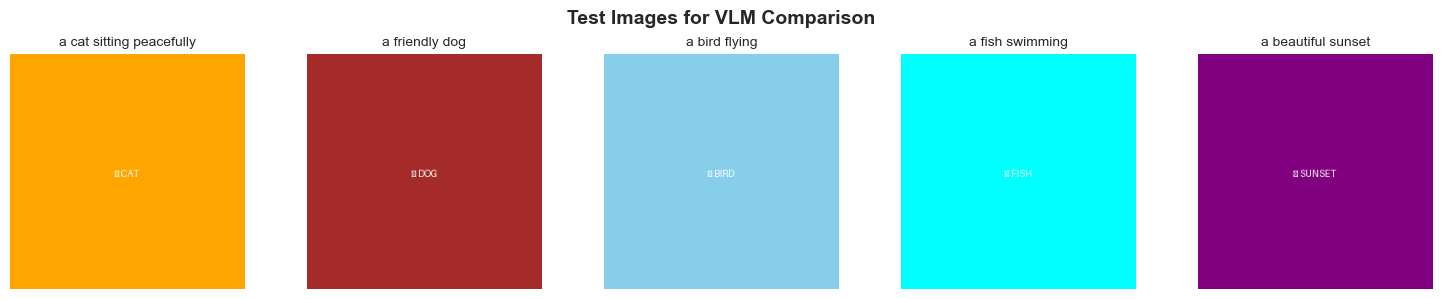

In [4]:
# =============================================================================
# CELL 4: Display Test Images
# =============================================================================

# Display test images
fig, axes = plt.subplots(1, len(test_data), figsize=(15, 3))
for i, (img, prompt) in enumerate(test_data):
    axes[i].imshow(img)
    axes[i].set_title(prompt, fontsize=10)
    axes[i].axis('off')
plt.suptitle("Test Images for VLM Comparison", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
# =============================================================================
# CELL 5: Model Selection Logic
# =============================================================================

def auto_select_models():
    """Automatically select VLMs based on available GPU memory"""
    if not torch.cuda.is_available():
        print("⚠️  No CUDA GPU detected. Using CPU-friendly models only.")
        return ["clip"]
    
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"📊 Available GPU Memory: {total_memory:.1f} GB")
    
    if total_memory >= 26:
        selected = ["clip", "blip2", "instructblip", "llava-1.5"]
        print("🚀 High-end GPU detected! Testing all models.")
    elif total_memory >= 15:
        selected = ["clip", "blip2", "instructblip"]
        print("⚡ Mid-range GPU detected! Testing efficient models.")
    elif total_memory >= 8:
        selected = ["clip", "blip2"]
        print("💡 Standard GPU detected! Testing CLIP and BLIP-2.")
    else:
        selected = ["clip"]
        print("🔧 Low memory GPU detected! Testing CLIP only.")
    
    return selected

# Select models for this session
MODELS_TO_TEST = auto_select_models()
print(f"Selected models: {MODELS_TO_TEST}")

📊 Available GPU Memory: 25.8 GB
⚡ Mid-range GPU detected! Testing efficient models.
Selected models: ['clip', 'blip2', 'instructblip']


In [6]:
# =============================================================================
# CELL 6: Initialize VLM Comparator
# =============================================================================

# Initialize the VLM comparator
try:
    comparator = VLMComparator()
    print("✅ VLMComparator initialized successfully")
except Exception as e:
    print(f"❌ Failed to initialize VLMComparator: {e}")
    comparator = None

✅ VLMComparator initialized successfully


In [7]:
# =============================================================================
# CELL 7: Load Selected Models
# =============================================================================

loaded_models = []
model_info = {}

if comparator:
    print("🔄 Loading selected models...")
    for model_name in MODELS_TO_TEST:
        try:
            print(f"  Loading {model_name}...")
            comparator.load_model(model_name)
            loaded_models.append(model_name)
            print(f"  ✅ {model_name} loaded successfully")
        except Exception as e:
            print(f"  ❌ Failed to load {model_name}: {str(e)[:100]}...")
    
    # Get model information
    if loaded_models:
        model_info = comparator.get_model_comparison()
        print(f"\n🎉 Successfully loaded {len(loaded_models)} models: {loaded_models}")
    else:
        print("⚠️ No models were loaded successfully")
else:
    print("⚠️ Cannot load models - comparator not initialized")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🔄 Loading selected models...
  Loading clip...
  ✅ clip loaded successfully
  Loading blip2...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Failed to load blip2: 'NoneType' object has no attribute '__getstate__'


  ❌ Failed to load blip2: 'NoneType' object has no attribute '__getstate__'...
  Loading instructblip...


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  ✅ instructblip loaded successfully

🎉 Successfully loaded 2 models: ['clip', 'instructblip']


In [8]:
# =============================================================================
# CELL 8: Display Basic Model Comparison
# =============================================================================

if comparator and loaded_models:
    print("📊 VLM Model Comparison Table")
    print("=" * 80)
    comparator.print_comparison_table()
    print("✅ Basic comparison table displayed")
else:
    print("⚠️ Cannot display comparison table - models not loaded")

📊 VLM Model Comparison Table

VLM COMPARISON TABLE

📋 LLAVA-1.5
--------------------------------------------------
Parameters: 13B
Memory Usage: 26 GB

✅ Advantages:
  • Strong instruction following
  • Good at detailed image descriptions
  • Handles complex reasoning tasks
  • Large training dataset

❌ Disadvantages:
  • Large memory footprint (~13B params)
  • Susceptible to typographic attacks
  • Slower inference time
  • May hallucinate details

🛡️ Robustness Analysis:
  • Typographic Attack: 🔴 vulnerable
  • Adversarial Patches: 🟡 moderate
  • Image Corruption: 🟢 good
  • Prompt Injection: 🔴 vulnerable

📋 BLIP2
--------------------------------------------------
Parameters: 7B
Memory Usage: 15 GB

✅ Advantages:
  • Efficient architecture
  • Good image captioning
  • Faster inference than LLaVA
  • Better OOD generalization

❌ Disadvantages:
  • Limited instruction following
  • Less detailed responses
  • Weaker reasoning capabilities
  • Limited conversational ability

🛡️ Robust

In [9]:
# =============================================================================
# CELL 9: Detailed Model Specifications
# =============================================================================

if model_info and loaded_models:
    comparison_data = []
    
    # Use case mapping
    use_case_map = {
        'clip': 'Similarity & Efficiency',
        'blip2': 'Balanced Performance',
        'instructblip': 'Instruction Following',
        'llava-1.5': 'Detailed Analysis'
    }
    
    for model_name in loaded_models:
        if model_name in model_info:
            info = model_info[model_name]
            
            # Extract key strengths (first 2 advantages)
            key_strengths = ", ".join(info['advantages'][:2])
            
            comparison_data.append({
                'Model': model_name.upper(),
                'Memory (GB)': info['memory_gb'],
                'Parameters': info['params'],
                'Key Strengths': key_strengths,
                'Best Use Case': use_case_map.get(model_name, 'General Purpose')
            })
    
    if comparison_data:
        df = pd.DataFrame(comparison_data)
        print("📈 Detailed Model Specifications:")
        print(df.to_string(index=False))
    else:
        print("⚠️ No model data available for detailed comparison")
else:
    print("⚠️ Cannot display detailed specifications - model info not available")

📈 Detailed Model Specifications:
       Model  Memory (GB) Parameters                                               Key Strengths           Best Use Case
        CLIP            2       400M                   Very efficient, Good image-text alignment Similarity & Efficiency
INSTRUCTBLIP           12         7B Good instruction following, Balanced performance/efficiency   Instruction Following


In [10]:
# =============================================================================
# CELL 10: Model Summary Statistics
# =============================================================================

if model_info and loaded_models:
    print("📊 Quick Stats:")
    print(f"  Models loaded: {len(loaded_models)}")
    
    # Calculate memory statistics
    loaded_model_info = {m: model_info[m] for m in loaded_models if m in model_info}
    if loaded_model_info:
        total_memory = sum(info['memory_gb'] for info in loaded_model_info.values())
        memory_values = [info['memory_gb'] for info in loaded_model_info.values()]
        
        print(f"  Total memory required: {total_memory} GB")
        print(f"  Memory range: {min(memory_values)} - {max(memory_values)} GB")
        print(f"  Average memory per model: {total_memory/len(loaded_model_info):.1f} GB")
    else:
        print("  No memory statistics available")
else:
    print("⚠️ Cannot display statistics - model info not available")

📊 Quick Stats:
  Models loaded: 2
  Total memory required: 14 GB
  Memory range: 2 - 12 GB
  Average memory per model: 7.0 GB


In [11]:
# =============================================================================
# CELL 11: Basic Functionality Test
# =============================================================================

def test_basic_functionality(models, test_data):
    """Test basic response generation for each model"""
    results = {}
    
    print("🧪 Testing Basic VLM Functionality")
    print("=" * 50)
    
    for model_name in models:
        if not comparator or model_name not in comparator.models:
            print(f"⚠️ {model_name} not available, skipping...")
            continue
            
        print(f"\n🔍 Testing {model_name.upper()}:")
        model_results = []
        
        for i, (image, prompt) in enumerate(test_data[:3]):  # Test first 3 images
            try:
                if model_name == "clip":
                    # CLIP works differently - similarity scoring
                    response = comparator.generate_response(model_name, image, prompt)
                else:
                    # Other models generate text descriptions
                    response = comparator.generate_response(model_name, image, "What do you see in this image?")
                
                print(f"  Image {i+1}: {str(response)[:80]}...")
                model_results.append(response)
                
            except Exception as e:
                error_msg = f"Error: {str(e)[:50]}..."
                print(f"  Image {i+1}: {error_msg}")
                model_results.append(error_msg)
        
        results[model_name] = model_results
    
    return results

# Run basic functionality test
if comparator and loaded_models:
    basic_results = test_basic_functionality(loaded_models, test_data)
    print(f"\n✅ Basic functionality test completed for {len(basic_results)} models")
else:
    print("⚠️ Cannot run basic functionality test - models not available")
    basic_results = {}

🧪 Testing Basic VLM Functionality

🔍 Testing CLIP:
  Image 1: Similarity score: 0.2006...
  Image 2: Similarity score: 0.2079...
  Image 3: Similarity score: 0.2512...

🔍 Testing INSTRUCTBLIP:
  Image 1: What do you see in this image? The image features a bright orange background wit...
  Image 2: What do you see in this image? The image features a red background with a white ...
  Image 3: What do you see in this image? The image features a blue background with a white...

✅ Basic functionality test completed for 2 models


In [12]:
# =============================================================================
# CELL 12: Robustness Analysis
# =============================================================================

def test_robustness(models, test_image, test_prompt):
    """Test robustness against different attack types"""
    attack_types = ["typographic", "adversarial_patch", "corruption"]
    robustness_results = {}
    
    print("🛡️ VLM Robustness Analysis")
    print("=" * 50)
    
    for model_name in models:
        if model_name not in comparator.models:
            continue
        
        print(f"\n🔍 Testing {model_name.upper()} robustness:")
        model_robustness = {}
        
        for attack in attack_types:
            try:
                print(f"  Testing {attack} attack...")
                result = comparator.evaluate_robustness(
                    model_name, test_image, test_prompt, attack
                )
                
                score = result.get("robustness_score", 0.0)
                model_robustness[attack] = score
                print(f"    Robustness Score: {score:.3f}")
                
            except Exception as e:
                print(f"    Error: {str(e)[:50]}...")
                model_robustness[attack] = 0.0
        
        # Calculate average robustness
        avg_robustness = np.mean(list(model_robustness.values()))
        model_robustness['average'] = avg_robustness
        print(f"  Average Robustness: {avg_robustness:.3f}")
        
        robustness_results[model_name] = model_robustness
    
    return robustness_results

# Run robustness test
if comparator and loaded_models and test_data:
    test_image, test_prompt = test_data[0]  # Use first test image
    robustness_results = test_robustness(loaded_models, test_image, test_prompt)
    print("✅ Robustness analysis completed")
else:
    print("⚠️ Cannot run robustness test - requirements not met")
    robustness_results = {}

🛡️ VLM Robustness Analysis

🔍 Testing CLIP robustness:
  Testing typographic attack...
    Robustness Score: 0.500
  Testing adversarial_patch attack...
    Robustness Score: 0.500
  Testing corruption attack...
    Robustness Score: 0.500
  Average Robustness: 0.500

🔍 Testing INSTRUCTBLIP robustness:
  Testing typographic attack...
    Robustness Score: 1.000
  Testing adversarial_patch attack...
    Robustness Score: 1.000
  Testing corruption attack...
    Robustness Score: 0.385
  Average Robustness: 0.795
✅ Robustness analysis completed


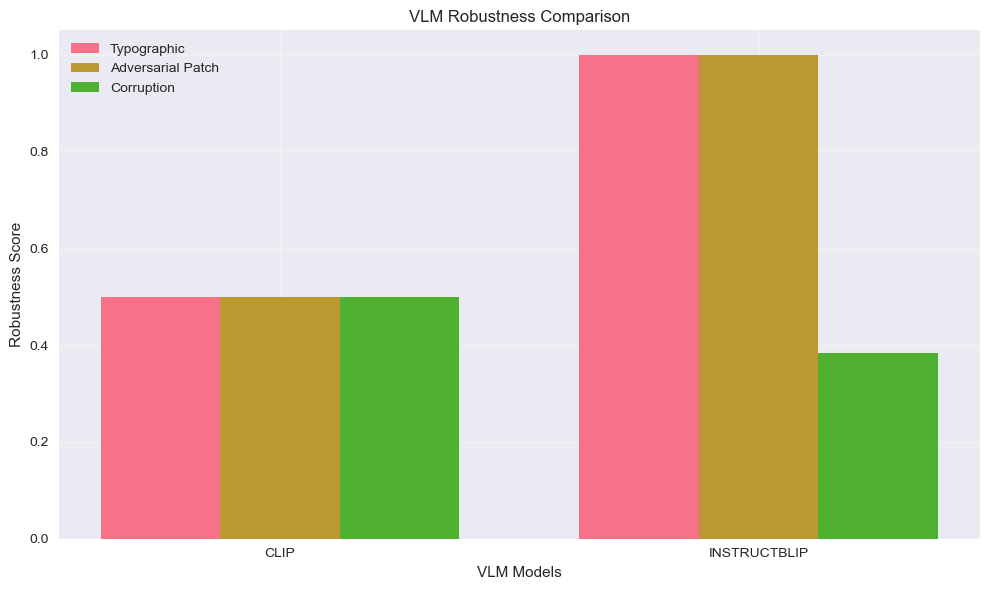

In [13]:
# =============================================================================
# CELL 13: Visualize Robustness Results
# =============================================================================

if robustness_results:
    models = list(robustness_results.keys())
    attacks = ['typographic', 'adversarial_patch', 'corruption']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))
    width = 0.25
    
    for i, attack in enumerate(attacks):
        scores = [robustness_results[model][attack] for model in models]
        ax.bar(x + i*width, scores, width, label=attack.replace('_', ' ').title())
    
    ax.set_xlabel('VLM Models')
    ax.set_ylabel('Robustness Score')
    ax.set_title('VLM Robustness Comparison')
    ax.set_xticks(x + width)
    ax.set_xticklabels([m.upper() for m in models])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No robustness results to visualize")

In [14]:
# =============================================================================
# CELL 14: Efficiency Benchmarking
# =============================================================================

def benchmark_efficiency(models, test_data):
    """Benchmark inference speed and memory usage"""
    efficiency_results = {}
    
    print("⚡ Efficiency Benchmarking")
    print("=" * 50)
    
    for model_name in models:
        if model_name not in comparator.models:
            continue
        
        print(f"\n⏱️ Benchmarking {model_name.upper()}:")
        
        # Measure inference time
        times = []
        for i, (image, prompt) in enumerate(test_data[:3]):  # Use subset for speed
            start_time = time.time()
            try:
                _ = comparator.generate_response(model_name, image, prompt)
                inference_time = time.time() - start_time
                times.append(inference_time)
                print(f"  Image {i+1}: {inference_time:.3f}s")
            except Exception as e:
                print(f"  Image {i+1}: Error - {str(e)[:30]}...")
                times.append(float('inf'))
        
        avg_time = np.mean([t for t in times if t != float('inf')])
        memory_usage = model_info[model_name]["memory_gb"] if model_name in model_info else 0
        throughput = 1 / avg_time if avg_time > 0 else 0
        
        efficiency_results[model_name] = {
            "avg_inference_time": avg_time,
            "memory_usage_gb": memory_usage,
            "throughput_imgs_per_sec": throughput
        }
        
        print(f"  Average Time: {avg_time:.3f}s")
        print(f"  Memory Usage: {memory_usage}GB")
        print(f"  Throughput: {throughput:.2f} imgs/sec")
    
    return efficiency_results

# Run efficiency benchmark
if comparator and loaded_models:
    efficiency_results = benchmark_efficiency(loaded_models, test_data)
    print("✅ Efficiency benchmarking completed")
else:
    print("⚠️ Cannot run efficiency benchmark - models not loaded")
    efficiency_results = {}

⚡ Efficiency Benchmarking

⏱️ Benchmarking CLIP:
  Image 1: 0.071s
  Image 2: 0.061s
  Image 3: 0.047s
  Average Time: 0.059s
  Memory Usage: 2GB
  Throughput: 16.84 imgs/sec

⏱️ Benchmarking INSTRUCTBLIP:
  Image 1: 0.207s
  Image 2: 0.190s
  Image 3: 0.355s
  Average Time: 0.251s
  Memory Usage: 12GB
  Throughput: 3.99 imgs/sec
✅ Efficiency benchmarking completed


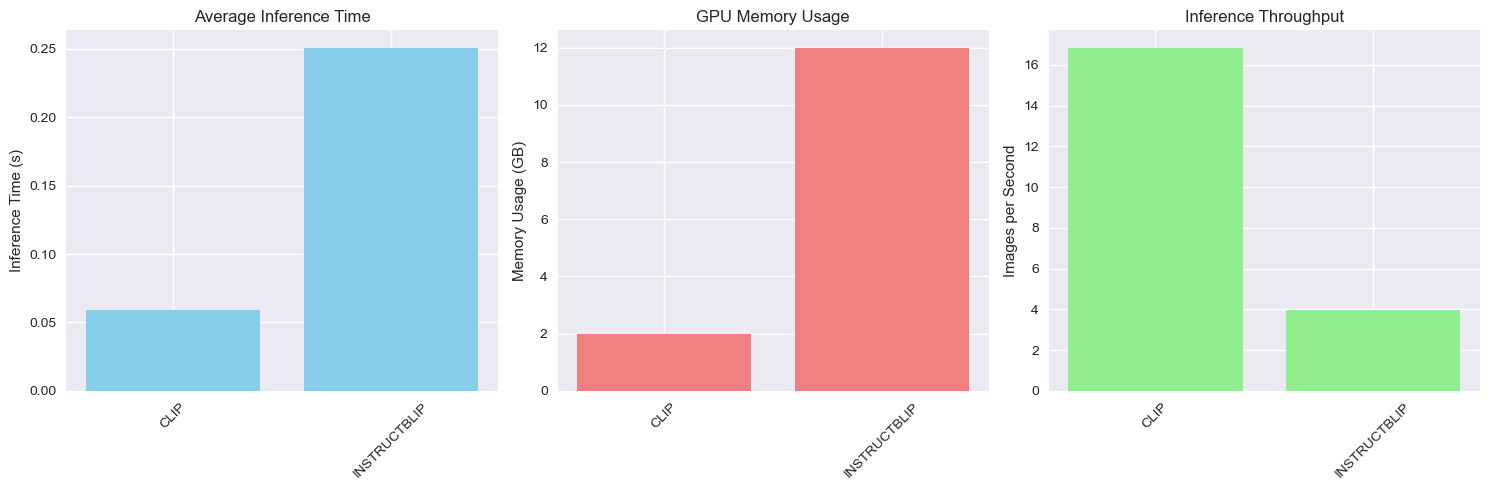

In [15]:
# =============================================================================
# CELL 15: Visualize Efficiency Results
# =============================================================================

if efficiency_results:
    models = list(efficiency_results.keys())
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Inference time
    times = [efficiency_results[m]["avg_inference_time"] for m in models]
    ax1.bar([m.upper() for m in models], times, color='skyblue')
    ax1.set_ylabel('Inference Time (s)')
    ax1.set_title('Average Inference Time')
    ax1.tick_params(axis='x', rotation=45)
    
    # Memory usage
    memory = [efficiency_results[m]["memory_usage_gb"] for m in models]
    ax2.bar([m.upper() for m in models], memory, color='lightcoral')
    ax2.set_ylabel('Memory Usage (GB)')
    ax2.set_title('GPU Memory Usage')
    ax2.tick_params(axis='x', rotation=45)
    
    # Throughput
    throughput = [efficiency_results[m]["throughput_imgs_per_sec"] for m in models]
    ax3.bar([m.upper() for m in models], throughput, color='lightgreen')
    ax3.set_ylabel('Images per Second')
    ax3.set_title('Inference Throughput')
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No efficiency results to visualize")

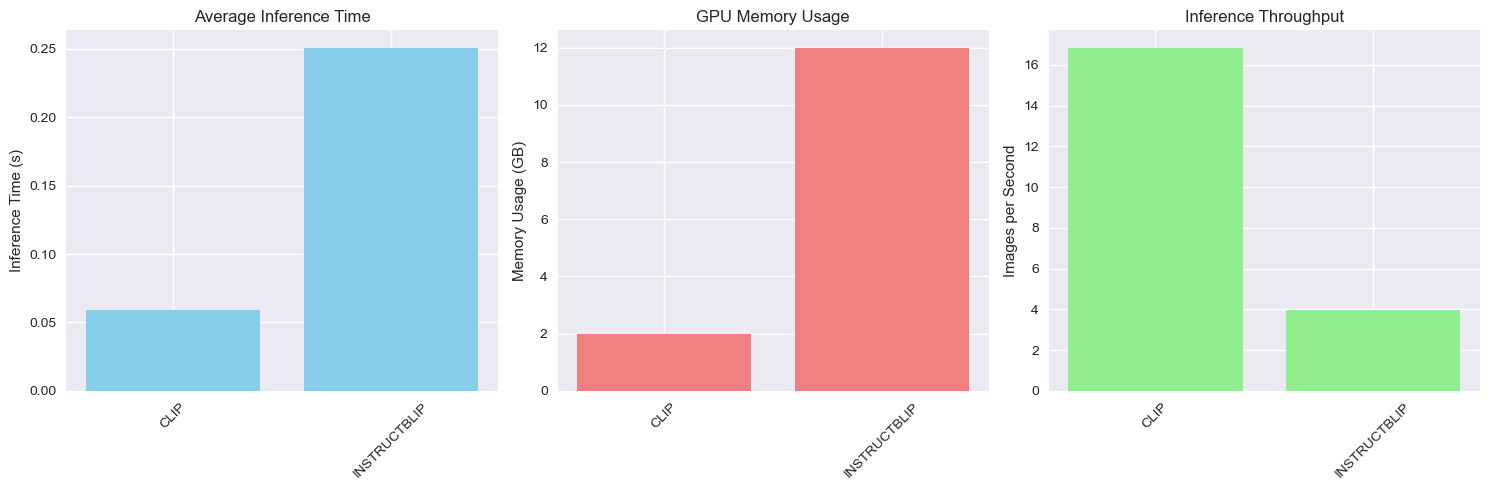

In [16]:
# =============================================================================
# CELL 15: Visualize Efficiency Results
# =============================================================================

if efficiency_results:
    models = list(efficiency_results.keys())
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Inference time
    times = [efficiency_results[m]["avg_inference_time"] for m in models]
    ax1.bar([m.upper() for m in models], times, color='skyblue')
    ax1.set_ylabel('Inference Time (s)')
    ax1.set_title('Average Inference Time')
    ax1.tick_params(axis='x', rotation=45)
    
    # Memory usage
    memory = [efficiency_results[m]["memory_usage_gb"] for m in models]
    ax2.bar([m.upper() for m in models], memory, color='lightcoral')
    ax2.set_ylabel('Memory Usage (GB)')
    ax2.set_title('GPU Memory Usage')
    ax2.tick_params(axis='x', rotation=45)
    
    # Throughput
    throughput = [efficiency_results[m]["throughput_imgs_per_sec"] for m in models]
    ax3.bar([m.upper() for m in models], throughput, color='lightgreen')
    ax3.set_ylabel('Images per Second')
    ax3.set_title('Inference Throughput')
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No efficiency results to visualize")

In [17]:
# =============================================================================
# CELL 16: Test Reward Functions
# =============================================================================

def test_reward_functions(models, test_data):
    """Test different VLM reward functions"""
    print("🎯 Testing VLM Reward Functions")
    print("=" * 50)
    
    # Prepare test data for reward functions
    test_images = np.array([np.array(img) for img, _ in test_data])
    test_prompts = [prompt for _, prompt in test_data]
    
    reward_results = {}
    
    for model_name in models:
        try:
            print(f"\n🔍 Testing {model_name.upper()} reward function:")
            
            # Select appropriate reward function
            if model_name == "clip":
                reward_fn = rewards.clip_similarity()
            elif model_name == "blip2":
                reward_fn = rewards.blip2_alignment()
            elif model_name == "instructblip":
                reward_fn = rewards.instructblip_reward()
            else:
                print(f"  No reward function available for {model_name}")
                continue
            
            # Compute rewards
            scores, info = reward_fn(
                test_images, 
                test_prompts, 
                [{}] * len(test_prompts)
            )
            
            reward_results[model_name] = {
                "scores": scores.tolist(),
                "prompts": test_prompts,
                "info": info,
                "mean_score": float(np.mean(scores)),
                "std_score": float(np.std(scores))
            }
            
            print(f"  Mean Score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            for prompt, score in zip(test_prompts, scores):
                print(f"    '{prompt}': {score:.4f}")
                
        except Exception as e:
            print(f"  Error testing {model_name}: {str(e)[:50]}...")
    
    return reward_results

# Test reward functions
if loaded_models and test_data:
    reward_results = test_reward_functions(loaded_models, test_data)
    print("✅ Reward function testing completed")
else:
    print("⚠️ Cannot test reward functions - requirements not met")
    reward_results = {}

🎯 Testing VLM Reward Functions

🔍 Testing CLIP reward function:
  Mean Score: 0.2218 ± 0.0238
    'a cat sitting peacefully': 0.2006
    'a friendly dog': 0.2079
    'a bird flying': 0.2512
    'a fish swimming': 0.2503
    'a beautiful sunset': 0.1990

🔍 Testing INSTRUCTBLIP reward function:


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


  Mean Score: 1.0000 ± 0.0000
    'a cat sitting peacefully': 1.0000
    'a friendly dog': 1.0000
    'a bird flying': 1.0000
    'a fish swimming': 1.0000
    'a beautiful sunset': 1.0000
✅ Reward function testing completed


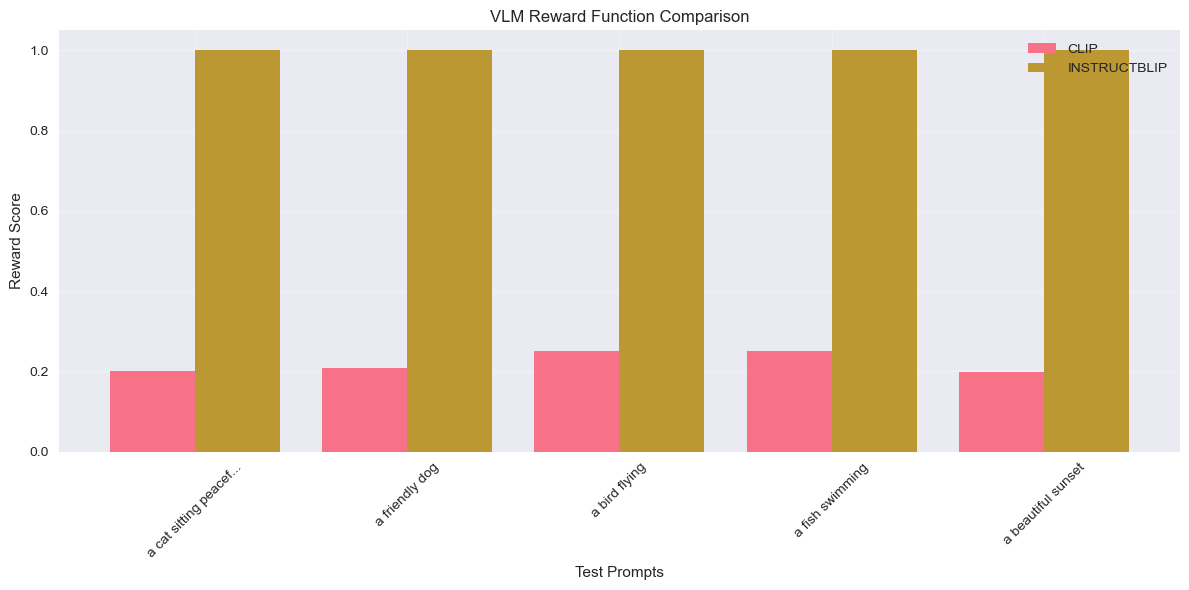

In [18]:
# =============================================================================
# CELL 17: Visualize Reward Scores
# =============================================================================

if reward_results and test_data:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models = list(reward_results.keys())
    prompts = [prompt for _, prompt in test_data]
    
    x = np.arange(len(prompts))
    width = 0.8 / len(models) if models else 1
    
    for i, model in enumerate(models):
        scores = reward_results[model]["scores"]
        ax.bar(x + i*width, scores, width, label=model.upper())
    
    ax.set_xlabel('Test Prompts')
    ax.set_ylabel('Reward Score')
    ax.set_title('VLM Reward Function Comparison')
    ax.set_xticks(x + width * (len(models)-1) / 2)
    ax.set_xticklabels([p[:20] + '...' if len(p) > 20 else p for p in prompts], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No reward results to visualize")

In [19]:
# =============================================================================
# CELL 18: Generate Final Report
# =============================================================================

def generate_final_report():
    """Generate a comprehensive report of all experiments"""
    
    report = {
        "experiment_info": {
            "models_tested": loaded_models,
            "test_images_count": len(test_data),
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
        },
        "basic_functionality": basic_results if 'basic_results' in locals() else {},
        "robustness_analysis": robustness_results if 'robustness_results' in locals() else {},
        "efficiency_benchmark": efficiency_results if 'efficiency_results' in locals() else {},
        "reward_functions": reward_results if 'reward_results' in locals() else {}
    }
    
    # Save to file
    output_dir = Path("./vlm_comparison_results")
    output_dir.mkdir(exist_ok=True)
    
    report_file = output_dir / f"vlm_comparison_report_{int(time.time())}.json"
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2, default=str)
    
    print(f"📄 Complete report saved to: {report_file}")
    
    # Print summary
    print("\n📈 EXPERIMENT SUMMARY")
    print("=" * 50)
    print(f"Models Successfully Tested: {len(loaded_models)}")
    print(f"Test Images: {len(test_data)}")
    print(f"Experiments Completed: {len([k for k, v in report.items() if v and k != 'experiment_info'])}")
    
    return report

# Generate final report
final_report = generate_final_report()
print("\n🎉 VLM Comparison Demo Complete!")

📄 Complete report saved to: vlm_comparison_results\vlm_comparison_report_1748909259.json

📈 EXPERIMENT SUMMARY
Models Successfully Tested: 2
Test Images: 5
Experiments Completed: 0

🎉 VLM Comparison Demo Complete!
